In [348]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from pandas import read_csv
from sklearn.utils import shuffle
from datetime import datetime
from pandas.core.computation.check import NUMEXPR_INSTALLED

### Cleaned Data without changes

In [349]:
#lade einfache Daten und wandle in einen Dataframe um
with open('fullData.json') as dataJson:
    data = json.load(dataJson)

In [350]:
df_data = pd.DataFrame(data)
df = df_data[df_data['session'].notna()]

df.head()

,clientId,elementId,timeStamp,type,siteName,date,clientX,clientY,session,height,width,browser,key
339,2567c85a-ad16,inputPet,824.2999999988824,mouseover,TestEinfach,2022-10-17T13:35:24.171Z,673,363,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,NaN,NaN
340,2567c85a-ad16,inputPet,858.2999999988824,mouseout,TestEinfach,2022-10-17T13:35:24.205Z,772,333,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,NaN,NaN
341,2567c85a-ad16,inputCountry,2005.2999999988824,mouseover,TestEinfach,2022-10-17T13:35:25.361Z,796,266,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,NaN,NaN
342,2567c85a-ad16,inputCountry,2296.5,focus,TestEinfach,2022-10-17T13:35:25.652Z,NaN,NaN,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,Chrome,NaN
343,2567c85a-ad16,inputHouse,2875.2999999988824,mouseover,TestEinfach,2022-10-17T13:35:26.230Z,995,264,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,NaN,NaN


In [351]:
#get all events which are actually in TestSchwer
array_input_schwer = ['inputHobby','inputCancelor','inputTemperature','inputDays','inputRiver', 'inputDifficultQuestion', 'clickHere', 'buttonYes', 'alibiClick']

df_einfach_without_schwerInput = df[~df['elementId'].isin(array_input_schwer)]
df_schwer_without_einfachInput = df[df['elementId'].isin(array_input_schwer)]

df_actually_schwer = df_einfach_without_schwerInput.loc[df_einfach_without_schwerInput['siteName'] == 'TestSchwer']
df_easy = df_actually_schwer.assign(sitename='TestSchwer')

df_einfach = df_einfach_without_schwerInput.loc[~(df_einfach_without_schwerInput['siteName'] == 'TestSchwer')]
df_schwer = pd.concat([df_easy, df_schwer_without_einfachInput])

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [352]:
df_schwer['siteName'] = 'TestSchwer'

In [313]:
#Gleich viele sessions bei TestSchwer und TestEinfach
sessionIdSchwer = df_schwer['session']
sessionIdEinfach = df_einfach['session']

df_einfach['is_duplicated'] = df_einfach.duplicated('session')
#89 ids auf Seite Einfach
setEinfach = set(sessionIdEinfach)
length = len(setEinfach)
print(length)

#70 ids auf Seite Schwer
df_schwer['is_duplicated'] = df_schwer.duplicated('session')
setSchwer = set(sessionIdSchwer)
lengthSchwer = len(setSchwer)
print(lengthSchwer)

89
70


<ipython-input-313-e5deec7b960a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_einfach['is_duplicated'] = df_einfach.duplicated('session')


In [314]:
in_schwer_but_not_in_einfach = setSchwer - setEinfach
in_einfach_but_not_in_schwer = setEinfach - setSchwer

array_einfach = list(in_einfach_but_not_in_schwer)
array_schwer = list(in_schwer_but_not_in_einfach)

#66 Teilnehmer bzw. Sessions
df_einfach_without_ids = df_einfach[~df_einfach['session'].isin(array_einfach)]
df_schwer_without_ids = df_schwer[~df_schwer['session'].isin(array_schwer)]

df_einfach_final = df_einfach_without_ids.drop(['clientId', 'is_duplicated'], axis=1)
df_schwer_final = df_schwer_without_ids.drop(['clientId', 'is_duplicated'], axis=1)

print("Anzahl der Session-Ids bei einfach", 89 - len(array_einfach))
print("Anzahl der Session-Ids bei schwer",70 - len(array_schwer))

Anzahl der Session-Ids bei einfach 66
Anzahl der Session-Ids bei schwer 66


In [393]:
#next Button wurde anscheinend nicht immer übertragen lol --> deswegen müssen wir schauen ob die gleich adresse auf der anderne Seite ist 
df_test = df_einfach_final.loc[df_einfach_final['elementId'] == 'nextButton']
print(df_test)

       elementId           timeStamp   type     siteName  \
364   nextButton  18874.400000000373  click  TestEinfach   
540   nextButton               59121  click  TestEinfach   
1036  nextButton               19187  click  TestEinfach   
1070  nextButton               13679  click  TestEinfach   

                          date clientX clientY  session height width browser  \
364   2022-10-17T13:35:42.223Z     NaN     NaN      699    944  1920  Chrome   
540   2022-10-17T13:41:41.254Z     NaN     NaN      192    990  1792  Safari   
1036  2022-10-17T13:52:05.111Z     NaN     NaN      830    990  1792  Safari   
1070  2022-10-17T13:52:35.059Z     NaN     NaN      293    395   390  Safari   

      key  
364   NaN  
540   NaN  
1036  NaN  
1070  NaN  


In [411]:
array_session_einfach = ['f3a6d5da-7857-ab9a-bcaf-ffa678540500', '0eb0e508-a337-0a7e-490d-5bb67ea8605a', '7e78ac93-8a2f-39d2-26a1-c41c7804b2e2', 'c9f551e4-927d-b2bf-aa77-6c49231d51df', 'edeac185-2198-1a32-1bf4-dd0816811064', 'd6e55e9b-a662-53a8-a261-4a0a362e30c3', '06d4d87e-940f-973f-a09f-74fff7d0b83a', '8abf06f5-52ae-6b8a-2203-b8e5967621d3', '51f4db5a-4b60-df29-b773-12ad99d4781e', '0a0fdcc9-ebf8-371b-40bf-efe88d97e22e', 'f4fd1505-cec6-5f69-18de-bceac07666e6', 'c84ddb60-e23a-cd84-ab83-ba030d4c4a73', 'fba8ac2f-02c2-130b-254f-3bcebe67d451', 'f090c908-bb4c-fdca-942d-6ae02b4019b0', '62c1e7a3-3ae8-ea78-a6fa-5b0c8e6a4b90', 'a8edf9d6-fb31-5690-e4be-3fa68ae2ff4a', 'ce22d53f-16a7-8e19-de32-641cffee9cae', 'c2fccaf4-aa23-d3bb-291b-2ce8e083512a', 'cde8b105-35ba-2b75-2f62-7d2d538c9dca', '047b635d-224e-f897-c995-3a9cac2df78a', '5db6c1c8-a5d3-37a1-848e-71c29c4dd002', 'b66c82e2-5869-5ecc-0d81-1c7d55671ec8', '7fe95a48-d9bd-2059-b731-0da1e54a4618']
df_click_einfach = df_einfach[df_einfach['session'].isin(array_session_einfach)]

#df_click_einfach['session'].value_counts()

df_click_einfach.loc[df_click_einfach['elementId'] == 'inputEasyQuestion']
df_click_einfach.sort_values(['session', 'timeStamp'])
df_sroll = df_click_einfach.loc[df_click_einfach["type"] !="scroll"]

df_sroll['session'].value_counts()


# df_click_einfach.sort_values(['session', 'timeStamp'])
# df = df_click_einfach.loc[df_click_einfach['elementId'] == 'inputEasyQuestion']

c84ddb60-e23a-cd84-ab83-ba030d4c4a73    39
5db6c1c8-a5d3-37a1-848e-71c29c4dd002    27
ce22d53f-16a7-8e19-de32-641cffee9cae    25
f3a6d5da-7857-ab9a-bcaf-ffa678540500    13
c9f551e4-927d-b2bf-aa77-6c49231d51df    10
fba8ac2f-02c2-130b-254f-3bcebe67d451     8
0a0fdcc9-ebf8-371b-40bf-efe88d97e22e     5
c2fccaf4-aa23-d3bb-291b-2ce8e083512a     5
8abf06f5-52ae-6b8a-2203-b8e5967621d3     4
62c1e7a3-3ae8-ea78-a6fa-5b0c8e6a4b90     4
edeac185-2198-1a32-1bf4-dd0816811064     4
047b635d-224e-f897-c995-3a9cac2df78a     3
f090c908-bb4c-fdca-942d-6ae02b4019b0     3
a8edf9d6-fb31-5690-e4be-3fa68ae2ff4a     2
0eb0e508-a337-0a7e-490d-5bb67ea8605a     2
7e78ac93-8a2f-39d2-26a1-c41c7804b2e2     2
7fe95a48-d9bd-2059-b731-0da1e54a4618     2
f4fd1505-cec6-5f69-18de-bceac07666e6     2
d6e55e9b-a662-53a8-a261-4a0a362e30c3     1
06d4d87e-940f-973f-a09f-74fff7d0b83a     1
b66c82e2-5869-5ecc-0d81-1c7d55671ec8     1
cde8b105-35ba-2b75-2f62-7d2d538c9dca     1
Name: session, dtype: int64

In [410]:
df_einfach_final['session'].value_counts()

192    51
202    43
840    42
513    42
771    39
918    38
930    37
753    32
384    32
325    32
442    31
830    31
189    30
320    30
294    28
897    28
576    27
151    26
654    26
699    26
483    26
884    26
945    26
176    26
881    26
348    25
746    25
129    25
293    25
703    24
311    24
234    24
742    24
444    24
744    24
604    24
845    24
185    24
489    24
359    23
644    22
894    22
821    22
297    22
775    22
707    20
468    20
263    20
133    20
527    20
750    19
193    19
673    19
777    19
314    19
857    18
175    18
659    18
177    18
482    16
999    14
475    10
243     8
559     8
525     4
584     2
Name: session, dtype: int64

In [315]:
df_schwer_final['siteName'] = 'TestSchwer'

In [425]:
schwero = pd.read_pickle('CleanedDataWithIds.pkl')

schwer = schwero.loc[schwero['siteName'] == 'TestSchwer']
schwer_click = schwer.loc[schwer['elementId'] == 'clickHere']
schwer_nextButton = schwer.loc[schwer['elementId'] == 'nextButton']
schwer_key = schwer.loc[schwer['type'] == 'keydown']

#schwer_click['session'].value_counts()
#schwer_nextButton['session'].value_counts()
schwer_key['session'].value_counts()



544    197
985     86
337     76
365     72
650     63
488     53
389     48
191     48
664     47
395     43
853     42
205     38
803     35
932     33
288     29
546     27
983     24
274     23
138     20
786     20
451     19
456     19
739     17
341     16
884     15
134     13
479     11
517      9
979      7
128      7
910      7
553      7
200      6
921      6
299      5
542      5
781      5
855      5
434      4
744      4
691      4
631      4
468      2
904      1
Name: session, dtype: int64

In [426]:
einfach = schwero.loc[schwero['siteName'] == 'TestEinfach']
einfach_key = einfach.loc[einfach['type'] == 'keydown']

einfach_key['session'].count()

91

In [316]:
df_data_without_scroll = pd.concat([df_einfach_final, df_schwer_final])
df_data_without_scroll = df_data_without_scroll.loc[df_data_without_scroll["type"] !="scroll"]
df_tmp = shuffle(df_data_without_scroll)
#df_tmp.to_pickle('CleanedDataWithoutChange.pkl')

/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:238: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  curves.iloc[:, cols] = (curves
/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<Figure size 720x432 with 0 Axes>

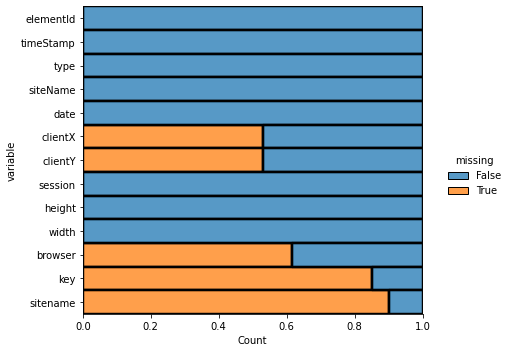

In [317]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.displot(
    data=df_data_without_scroll.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)

In [318]:
df_data_without_scroll['siteName'].value_counts()

TestSchwer     7279
TestEinfach    1603
Name: siteName, dtype: int64

Text(0.5, 1.0, 'Counts for Types')

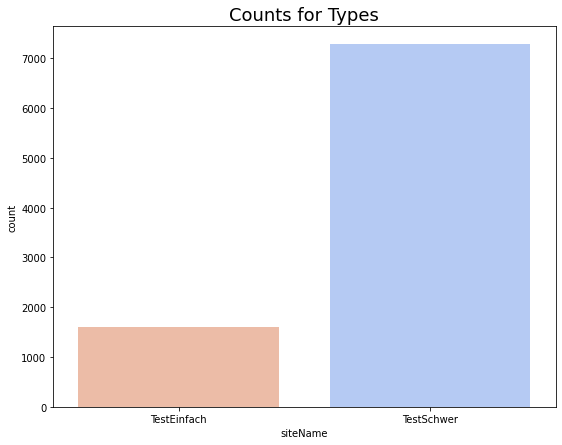

In [319]:
# Figure size
plt.figure(figsize=(9,7))
# Count plot
ax = sns.countplot(x = 'siteName', data = df_data_without_scroll, palette="coolwarm_r")
# Add title
plt.title('Counts for Types', fontsize=18)

In [320]:
df_einfach_final['type'].value_counts()

scroll       2483
mouseover     380
mouseout      379
blur          375
focus         374
keydown        91
click           4
Name: type, dtype: int64

Text(0.5, 1.0, 'Counts for Types')

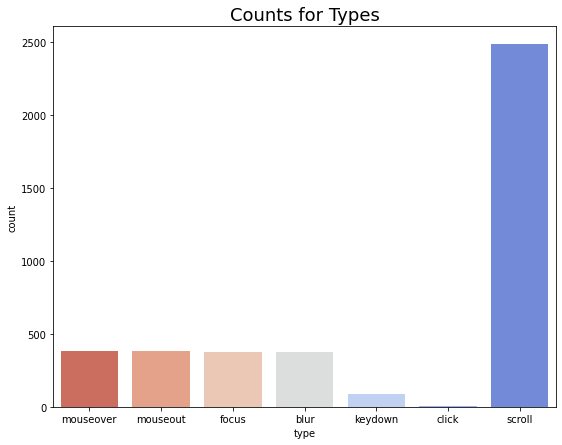

In [321]:
#count of easy
# Figure size
plt.figure(figsize=(9,7))
# Count plot
ax = sns.countplot(x = 'type', data = df_einfach_final, palette="coolwarm_r")
# Add title
plt.title('Counts for Types', fontsize=18)

In [322]:
df_schwer_final['type'].value_counts()

scroll       23799
mouseover     1706
mouseout      1696
keydown       1222
blur          1028
focus         1002
click          625
Name: type, dtype: int64

Text(0.5, 1.0, 'Counts for Types')

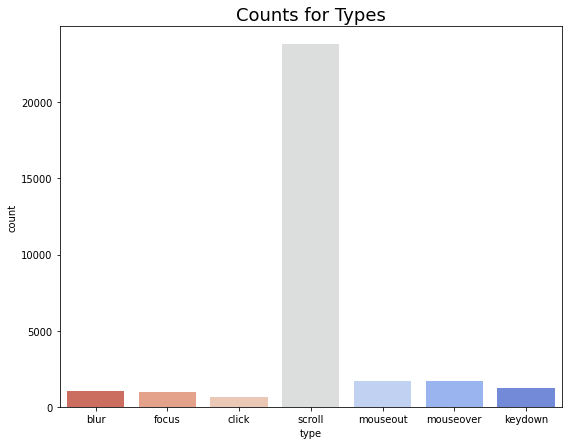

In [323]:
#count of easy
# Figure size
plt.figure(figsize=(9,7))
# Count plot
ax = sns.countplot(x = 'type', data = df_schwer_final, palette="coolwarm_r")
# Add title
plt.title('Counts for Types', fontsize=18)

In [324]:
df_schwer_final = df_schwer_final.loc[df_schwer_final["type"] !="scroll"]
df_einfach_final = df_einfach_final.loc[df_einfach_final["type"] !="scroll"]

In [325]:
# df2 = df_einfach_final.sort_values(['session', 'date'],
#               ascending = [True, True])

In [326]:
# print(len(df_einfach_final))
# print(len(df_schwer_final))

# df_einfach_final['type'].value_counts()


In [327]:
# df_schwer_final['type'].value_counts()

In [328]:
df_data_without_scroll = df_data_without_scroll.loc[df_data_without_scroll["type"] !="scroll"]
df_data_without_scroll['siteName'] = df_data_without_scroll['siteName'].replace('TestSchwer', 1)
df_data_without_scroll['siteName'] = df_data_without_scroll['siteName'].replace('TestEinfach', 0)

### Cleaned Data with other session Ids

In [329]:
# new sessionId 
import random
from random import choice
import collections

array_of_ids_einfach = df_einfach_final['session'].value_counts().index.tolist()
array_of_ids_schwer = df_schwer_final['session'].value_counts().index.tolist()
numbers_schwer = []

random_numbers_ids_einfach = random.sample(range(101,1000), len(array_of_ids_einfach))
for i in range(len(random_numbers_ids_einfach)):
    random_numbers_ids_schwer = random.choice([i for i in range(101, 1000) if i not in random_numbers_ids_einfach])
    numbers_schwer.append(random_numbers_ids_schwer)

numbers = random_numbers_ids_einfach + numbers_schwer

df_einfach_final['session'] = df_einfach_final['session'].replace(array_of_ids_einfach, random_numbers_ids_einfach)
df_schwer_final['session'] = df_schwer_final['session'].replace(array_of_ids_schwer, numbers_schwer)

print([item for item, count in collections.Counter(numbers).items() if count > 1])

[108, 947, 863, 303, 110]


In [330]:
df_new_ids = pd.concat([df_einfach_final, df_schwer_final])

In [331]:
#df_new_ids.to_pickle('CleanedDataWithIds.pkl')

In [332]:
import imblearn
print(imblearn.__version__)

0.9.1


In [333]:
df_sessions = pd.read_pickle('SortedBySessions.pkl')

In [334]:
df_sessions.head()

,session,count_mouseover,count_mouseout,count_click,count_blur,count_focus,count_keydown,duration,height,width,siteName
0,517,13,13,4,23,22,9,528.129,661,360,TestSchwer
1,534,5,5,0,6,6,2,12.241,664,390,TestEinfach
3,543,6,6,0,6,6,4,19.673,669,390,TestEinfach
4,544,256,256,33,117,116,197,1270.171,962,1724,TestSchwer
5,546,32,32,7,26,28,27,135.360,1312,1479,TestSchwer


In [335]:
df_cleaned = pd.read_pickle('CleanedDataWithIds.pkl')


In [336]:
one_hot_encoded_data = pd.get_dummies(df_cleaned, columns = ['elementId', 'type'])

In [337]:
# import seaborn as sns
# sns.scatterplot(data=df_cleaned, x="type", y="timeStamp", hue="siteName")

In [338]:
# sns.scatterplot(data=df_data_without_scroll, x="timeStamp", y="type", hue="siteName")

In [339]:
# einfach = df_data_without_scroll.loc[df_data_without_scroll['siteName'] == 0]
# schwer = df_data_without_scroll.loc[df_data_without_scroll['siteName'] == 1]

In [340]:
# sns.scatterplot(data=df_data_without_scroll, x='timeStamp', y="type", hue="siteName")

In [341]:
# plt.figure(figsize=(10,6))
# sns.scatterplot(data=df_data_without_scroll, x='timeStamp', y="type", hue="siteName", palette="Set2")

In [342]:
df_sessions.describe()

,session,count_mouseover,count_mouseout,count_click,count_blur,count_focus,count_keydown,duration
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,577.372093,15.806202,15.720930,3.674419,10.581395,10.372093,10.093023,131.255326
std,263.755926,28.734528,28.762491,8.687422,13.189542,13.130398,23.580130,233.926732
min,109.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005000
25%,341.000000,4.000000,4.000000,0.000000,6.000000,6.000000,0.000000,16.756000
50%,597.000000,6.000000,6.000000,0.000000,6.000000,6.000000,1.000000,25.472000
75%,786.000000,15.000000,15.000000,3.000000,12.000000,12.000000,7.000000,190.533000
max,998.000000,256.000000,256.000000,63.000000,117.000000,116.000000,197.000000,1623.542000


In [343]:
df_session_einfach = df_sessions.loc[df_sessions["siteName"] == "TestEinfach"]
df_session_schwer = df_sessions.loc[df_sessions["siteName"] == "TestSchwer"]

In [346]:
df_session_einfach.describe()

,session,count_mouseover,count_mouseout,count_click,count_blur,count_focus,count_keydown,duration
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,601.469697,5.757576,5.742424,0.060606,5.681818,5.666667,1.378788,20.652530
std,258.191296,3.210850,3.221613,0.240435,1.737895,1.721657,2.292229,13.537414
min,109.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.005000
25%,387.750000,4.000000,3.250000,0.000000,6.000000,6.000000,0.000000,13.826750
50%,636.500000,6.000000,6.000000,0.000000,6.000000,6.000000,0.000000,18.071000
75%,820.500000,6.000000,6.000000,0.000000,6.000000,6.000000,2.000000,23.394000
max,998.000000,17.000000,17.000000,1.000000,8.000000,8.000000,11.000000,79.181000


In [345]:
df_session_schwer.describe()

,session,count_mouseover,count_mouseout,count_click,count_blur,count_focus,count_keydown,duration
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,552.126984,26.333333,26.174603,7.460317,15.714286,15.301587,19.222222,247.124921
std,269.199680,38.388926,38.470994,11.282052,17.425814,17.451902,31.255164,293.457366
min,128.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.786000
25%,318.000000,5.500000,5.500000,0.000000,5.000000,4.500000,0.000000,37.243500
50%,544.000000,15.000000,15.000000,4.000000,12.000000,12.000000,7.000000,195.613000
75%,762.500000,35.000000,35.000000,8.500000,22.000000,21.500000,25.500000,300.721500
max,985.000000,256.000000,256.000000,63.000000,117.000000,116.000000,197.000000,1623.542000
